In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from scipy.special import erfcinv
from scipy.optimize import curve_fit, minimize
from scipy import stats
from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio, calculate_test_statistic


[0, 0.01689268139307387, 0, 0, 0.08401882101316005, 0, 0, 3.9340896298817825, 0.03997335993335582, 0.21127629085094668, 0, 0, 0.25965895407716744, 0, 0, 0, 0, 0, 0.5610989998094738, 1.5560299707576632, 0, 0, 0, 0, 0, 0.036077158350963145, 0, 0, 0, 0.08401882101316005, 2.179673287726473, 0, 0.2910765325941611, 1.036880570842186, 0, 1.606115086498903, 0, 0, 0.9378724262060132, 0, 0, 0, 0, 0.9378724262060132, 0, 0.04836454562610015, 0, 0, 0.622462997736875, 0, 0, 0.5610989998094738, 0, 0.03997335993335582, 0.8255994638020638, 0, 0.0015997866867110133, 0.9378724262060132, 0.1442174400726799, 2.6750162455718964, 0, 0, 0, 0, 0.0003999733307864517, 0.4346448299475014, 0, 0, 0, 0, 0.02558635754394345, 0, 0, 0, 1.119650855049258, 0, 0.502911180636147, 0.057553975202608854, 0.7547144887212198, 0, 0, 0, 0, 0.35928215223248117, 1.2946894782362506, 0, 0.01689268139307387, 0.6068243004265241, 0, 0, 0, 0.02558635754394345, 0, 0.0003999733307864517, 0, 0.04406916236621328, 0.16787073313025758, 0.18463

(array([704.,  78.,  42.,  33.,  24.,  18.,  25.,   8.,   7.,  11.,   8.,
          5.,   5.,   4.,   2.,   5.,   4.,   3.,   2.,   2.,   2.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.        ,  0.25614441,  0.51228881,  0.76843322,  1.02457762,
         1.28072203,  1.53686644,  1.79301084,  2.04915525,  2.30529966,
         2.56144406,  2.81758847,  3.07373287,  3.32987728,  3.58602169,
         3.84216609,  4.0983105 ,  4.3544549 ,  4.61059931,  4.86674372,
         5.12288812,  5.37903253,  5.63517694,  5.89132134,  6.14746575,
         6.40361015,  6.65975456,  6.91589897,  7.17204337,  7.42818778,
         7.68433219,  7.94047659,  8.196621  ,  8.4527654 ,  8.70890981,
         8.96505422,  9.22119862,  9.47734303,  9.73348743,  9.98963184,
        10.24577625, 10.50192065, 10.75806506, 11.01420947, 11.27035387,
 

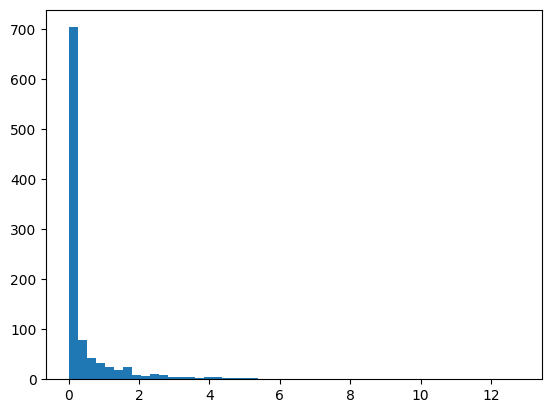

In [2]:
mean_events = 10000

def pseudoexperiment(seed = 0):

    background = 10000
    observed =  np.random.poisson(mean_events, 1)[0]

    ########## Likelihoods ##########
    def likelihood_function(b, s, N):
        return -2 * (stats.poisson.logpmf(N, b + s) )


    # Null hypothesis: s = 0 with PROFILED b. We need to minimize the likelihood to get the best fit b given the total_B and total_B_error
    def null_likelihood_function(bprime):
        return likelihood_function(bprime, 0, observed)



    minimization = minimize(null_likelihood_function, 100, bounds = [(0, None)])
    post_fit_B = minimization.x[0]

    null_likelihood = null_likelihood_function(background)
    likelihood = likelihood_function(observed, 0, observed)


    test_statistic =  (null_likelihood - likelihood)
    
    if observed < background:
        test_statistic = 0

    return test_statistic

    print("Seed: ", seed)
    print("Observed: ", observed)
    print("Best fit B: ", post_fit_B)


test_statistics = [pseudoexperiment(seed) for seed in range(1000)]
print(test_statistics)
plt.hist(test_statistics, bins = 50)

Median:  0.0
1sigma:  0.0 0.9485017561977206
2sigma:  0.0 1.9640810948815295
Percentile of 0:  0.0
Percentile of Z = 1:  0.857
Percentile of Z = 2:  0.976


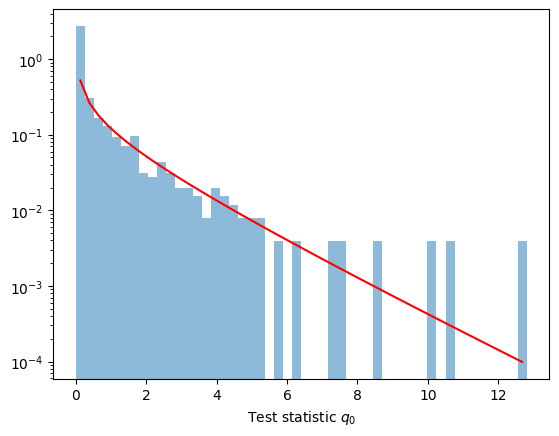

In [3]:
z_score = np.sqrt(test_statistics)
z_score = np.sort(z_score)
plt.hist(test_statistics, bins = 50, density = True, alpha = 0.5)

counts, bins = np.histogram(test_statistics, bins = 50, density = True)
centers = (bins[:-1] + bins[1:]) / 2

def f(q):
    return 1/(2*np.sqrt(q * 2 * np.pi)) * np.exp(-q/2)

plt.plot(centers, f(centers), label = "Asymptotic", color = "red")

plt.yscale("log")
plt.xlabel("Test statistic $q_0$")

# Print the median, 1sigma, and 2sigma values
print("Median: ", np.median(z_score))
print("1sigma: ", np.percentile(z_score, 16), np.percentile(z_score, 84))
print("2sigma: ", np.percentile(z_score, 2.5), np.percentile(z_score, 97.5))

# Print the percentile of z = 0, 1, 2
index = np.searchsorted(z_score, [0, 1, 2])
print("Percentile of 0: ", index[0] / len(z_score))
print("Percentile of Z = 1: ", index[1] / len(z_score))
print("Percentile of Z = 2: ", index[2] / len(z_score))

In [4]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 
    
feature_id = "mix_2"
bootstrap_flow = 0 # don't change this from 0

train_samesign = False
# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "SS"
else:
    train_data_id = "OS"

# train on opp sign means alt test set is samesign
if train_data_id == "OS": 
    alt_test_data_id = "SS"
elif train_data_id == "SS": 
    alt_test_data_id = "OS"

configs = "CATHODE_8"


# pickles contain all the results from the BDT training
working_dir = workflow["file_paths"]["working_dir"]
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/{configs}/"
pickle_save_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/pickles/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/"
plot_data_dir = "plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 1001
n_folds = 5

num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "quintic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic


In [5]:
# if train_samesign = False, this loads in the OS test data
# test 


def load_in_pseudoexperiments(file_string, num_pseudoexps):

    master_dict = {}

    with open(f"{pickle_save_dir}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
        loc_dict = pickle.load(ifile)
    master_dict = {**loc_dict}
    # load in the bootstraps
    for i in range(1, num_pseudoexps):
        with open(f"{pickle_save_dir}/bkg_samples/bootstrap{i}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
            loc_dict = pickle.load(ifile)
            master_dict[i] = loc_dict[0]
    return master_dict

num_to_plot = num_pseudoexperiments

all_test_data_splits = load_in_pseudoexperiments("all_test_data_splits", num_to_plot)
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
all_scores_splits = load_in_pseudoexperiments("all_scores_splits", num_to_plot)
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
all_alt_data_splits = load_in_pseudoexperiments("all_alt_data_splits", num_to_plot)
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)
# alt scores
all_alt_scores_splits = load_in_pseudoexperiments("all_alt_scores_splits", num_to_plot)

print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)

with open(f"{processed_data_dir}/mass_scaler_bootstrap{bootstrap_flow}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
with open(f"{processed_data_dir}/preprocessing_info_bootstrap{bootstrap_flow}", "rb") as ifile:
     preprocessing_info = pickle.load(ifile)

True
True
True
True


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
SB_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_left"])
SR_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_left"])
SR_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_right"])
SB_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_right"])

print(SB_left, SB_right)


data_prefix = f"upsilon_{train_data_id}"
print(data_prefix)

5.0 16.0
upsilon_OS


In [ ]:
def calculate_test_statistic_TEST(masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov, ONE_SIDED = True, verbose = False):

    # ########## Expected Counts -- Needed to construct the likelihoods ##########

    # Background Fit + Uncertainty
    B_function = fit_function(plot_centers_SR, *popt) 

    n = 1000
    temp_params = np.random.multivariate_normal(popt, pcov, n)
    y = np.array([fit_function(plot_centers_SR, *p) for p in temp_params])
    # B_error = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type) 
    

    # Null Hypothesis: The data comes from a single bin with mean B, and the Gaussian error on that mean is B_error
    total_B = sum(B_function)
    total_Bs = np.array([sum(y[i]) for i in range(n)])
    total_B_error = np.std(total_Bs)

    # Alternative hypothesis: The data comes from a single bin with mean S+B, and the Gaussian error on that mean is B_error
    num_total_in_SR = len(masses[(masses >= SR_left) & (masses <= SR_right)])
    total_S = num_total_in_SR - total_B
    total_S_error = np.sqrt(total_B_error**2)


    # Radha Test Statistic
    n = num_total_in_SR
    c = total_B
    sigma = total_B_error

    sqrt_factor = np.sqrt(c**2 - 2*c*sigma**2 + sigma**4 + 4*n*sigma**2)
    term1 = n + 0.5*(-c + sigma**2 - sqrt_factor)
    term2 = -(-c + 0.5*(c - sigma**2 + sqrt_factor))**2 / (2*(sigma**2 ))
    term3 = -n*np.log(n)
    term4 = n * np.log(0.5 * (c - sigma**2 + sqrt_factor))
    q0 = -2 * (term1 + term2 + term3 + term4)

    if total_S < 0 or total_B < 0:
        q0 = 0

    return total_S, total_B, q0 





    # If one-sided limits, then automatically return q_0 = 0
    if ONE_SIDED and (total_S < 0 or total_B < 0):
        q_0 = 0
        return total_S, total_B, q_0


    ########## Likelihoods ##########
    def likelihood_function(b, s, N):
        return -2 * (stats.poisson.logpmf(N, b + s) + stats.norm.logpdf(b, total_B, total_B_error))


    # Null hypothesis: s = 0 with PROFILED b. We need to minimize the likelihood to get the best fit b given the total_B and total_B_error
    def null_likelihood_function(bprime):
        return likelihood_function(bprime, 0, num_total_in_SR)

    minimization = minimize(null_likelihood_function, total_B + total_B_error, bounds = [(0, None)])
    post_fit_B = minimization.x[0]
    log_B = likelihood_function(post_fit_B, 0, num_total_in_SR)
    if verbose:
        print("pre_fit_B", total_B, " +- ", total_B_error   ,"post-fit B:", post_fit_B)

    # Alternative hypothesis: s = total_S. No need to profile b, since the best fit will just be total_B, and the best fit for s is N - B
    log_S_plus_B = likelihood_function(total_B, total_S, num_total_in_SR)

    # Calculate the test statistic
    q_0 = log_B - log_S_plus_B
    return total_S, total_B, q_0
     


In [25]:
n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -4, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff



n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -4, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff


        
def TEST_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, mass_scalar):
            

    num_experiments = num_pseudoexperiments
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))
    significances = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))


    for pseudo_e in range(num_experiments):

        data_dict_by_fold = dataset_by_pseudo_e[pseudo_e]
        scores_dict_by_fold = scores_by_pseudo_e[pseudo_e]

        all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
        all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
        all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
        in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
        in_SBL = (all_masses < SR_left )
        in_SBH = (all_masses > SR_right )

        mass_SBL = all_masses[in_SBL]
        mass_SR = all_masses[in_SR]
        mass_SBH = all_masses[in_SBH]

        feature_SBL = all_scores[in_SBL]
        feature_SR = all_scores[in_SR]
        feature_SBH = all_scores[in_SBH]
        
        # # Get a list of all possible cuts for the feature
        # feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)

        #  # For each cut, calculate the number of signal and background events in the SR
        # num_in_SBL = []
        # num_in_SR = []
        # num_in_SBH = []
        # FPR = []
        # # for cut in feature_cut_points:
        # #     num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
        # #     num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
        # #     num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

        # #     FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

        # # # feature_cut_points = np.linspace(np.min(feature_of_interest), np.max(feature_of_interest), 10000)

        fit_function = bkg_fit_quintic


        print(f"On pseudo experiment {pseudo_e+1}...")
        fpr_thresholds_test = [1,]
        for t, threshold in enumerate(fpr_thresholds_test ):


            # # Use interpolation to find the cut point that gives the desired FPR
            # best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


            mass_SBL_cut = mass_SBL
            mass_SR_cut = mass_SR
            mass_SBH_cut = mass_SBH

            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)

            # calculate significance of bump
            S,B, q0 = calculate_test_statistic_TEST(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov, verbose = True)
            
            n = 1000
            temp_params = np.random.multivariate_normal(popt, pcov, n)
            y = np.array([fit_function(plot_centers_SR, *p) for p in temp_params])

            # total_B = sum(B_function)
            total_Bs = np.array([sum(y[i]) for i in range(n)])
            total_B_error = np.std(total_Bs)

            # Null Hypothesis: The data comes from a single bin with mean B, and the Gaussian error on that mean is B_error
            # total_B = sum(B_function)
            
            print("S/sqrt(B+ErrB^2)", S/np.sqrt(B + total_B_error**2), f"Significance: {np.sqrt(q0)}", "sigma^2/B", total_B_error**2/B)
            significance = np.sqrt(q0)

            # q0 = S/np.sqrt(B + total_B_error**2)
            # if S < 0 or B < 0:
                # q0 = 0

            significances[t, pseudo_e] = np.sqrt(q0)

        
    
    return significances


On pseudo experiment 1...
1585.9512146793045 45.09444535545985
S/sqrt(B+ErrB^2) 1.756800029911208 Significance: 1.7449081036093015 sigma^2/B 1.2976131742049104
On pseudo experiment 2...
1534.200160404373 45.46116262513505
S/sqrt(B+ErrB^2) 1.8324865908311083 Significance: 1.8103283060017574 sigma^2/B 1.340128882041283
On pseudo experiment 3...
1701.4540394312207 45.11166732525365
S/sqrt(B+ErrB^2) -1.6195085871621397 Significance: 0.0 sigma^2/B 1.1721026538797183
On pseudo experiment 4...
1592.2248333030636 44.71060287131808
S/sqrt(B+ErrB^2) 0.4953319827318824 Significance: 0.4954158238184316 sigma^2/B 1.2694011411861115
On pseudo experiment 5...
1604.0539708102713 39.335236409716096
S/sqrt(B+ErrB^2) -0.40317327392804203 Significance: 0.0 sigma^2/B 1.0383982160255754
On pseudo experiment 6...
1613.5328197444728 49.248018596609846
S/sqrt(B+ErrB^2) -0.7736663529676997 Significance: 0.0 sigma^2/B 1.4388541330380376
On pseudo experiment 7...
1625.5918079965898 39.86380345490304
S/sqrt(B+ErrB

Text(0.5, 0.1, 'Asymptotic $f(q) = \\frac{1}{2}\\delta(q) + \\frac{1}{2}\\frac{1}{\\sqrt{2 \\pi q}}e^{-q/2}$')

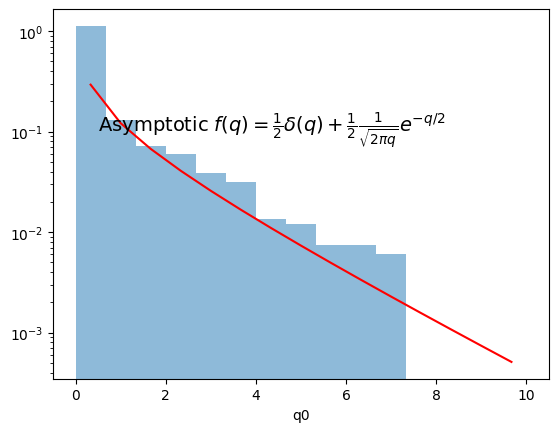

In [26]:
significances = TEST_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, scaler)[0]


key = "CATHODE"
print(significances)
z_score = significances
z_score = np.sort(z_score)

# Print the median, 1sigma, and 2sigma values
print("Median: ", np.median(z_score))
print("1sigma: ", np.percentile(z_score, 16), np.percentile(z_score, 84))
print("2sigma: ", np.percentile(z_score, 2.5), np.percentile(z_score, 97.5))

# Print the percentile of z = 0, 1, 2
index = np.searchsorted(z_score, [0, 1, 2])
print("Percentile of 0: ", index[0] / len(z_score))
print("Percentile of Z = 1: ", index[1] / len(z_score))
print("Percentile of Z = 2: ", index[2] / len(z_score))

counts, bins = np.histogram(significances**2, bins = 15, density = True, range = (0, 10))
centers = (bins[:-1] + bins[1:]) / 2

plt.hist(significances**2, bins = 15, density = True, alpha = 0.5, range = (0, 10))

def f(q):
    return 1/(2*np.sqrt(q * 2 * np.pi)) * np.exp(-q/2)

plt.plot(centers, f(centers), color = "red")
plt.yscale("log")
plt.xlabel("q0")

text = r"Asymptotic $f(q) = \frac{1}{2}\delta(q) + \frac{1}{2}\frac{1}{\sqrt{2 \pi q}}e^{-q/2}$"
plt.text(0.5, 0.1, text, fontsize = 14)
